In [1]:
import sys 
import os 
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
sys.path.append('../')
import glob
import tqdm


In [2]:
from src.utils.normalizer import Normalizer

In [ ]:
def calculate_C(samples):
    """
    Calculates the C if the samples from a distribution are subgaussian
    """
    
    samples_demeaned = samples.flatten()# - torch.mean(samples)
    
    #calculate the absolute cdf
    X = torch.sort(torch.abs(samples_demeaned))[0]
    log_y = torch.log(torch.arange(1, len(X)+1, device = X.device,
                     )) - np.log(2*len(X))
    
    #for a subgaussian P(|X| > t) <= 2 exp(-t^2/C^2)
    #so calculate the max C 
    # print("y= ", y)
    Cs = X / torch.sqrt(- log_y)
    # print(f"Cs = {Cs}")
    C = torch.max(Cs[torch.isfinite(Cs)])
    # print(f"C = {C}")
    return C.item(), [x, log_y]

# def calculate_C(samples):
#     return torch.max(samples).item()
    

In [50]:
# linear_layer = "layer_1/mlp.up_proj"

layers = glob.glob(f"/data/lliu/huffman/models/meta-llama/Llama-2-7b-hf/original_weights/*/*.pt")

device = torch.device("cuda:7")
Cs_orig = []
Cs_norm = []
with torch.no_grad():
    for linear_layer in tqdm.tqdm(layers):
        weight = torch.load(linear_layer, map_location=device)["weight"]
        
        C_orig = calculate_C(weight)
        # raise ValueError
        _,weight_normalized = Normalizer.normalize_init(weight, [0,1], [False,False],norm_rescale=True, powers=2,
                                                    p=2)
        
        C_norm = calculate_C(weight_normalized)
        
        Cs_orig.append(C_orig)
        Cs_norm.append(C_norm)
        
        
        
    

100%|██████████| 224/224 [00:13<00:00, 16.62it/s]


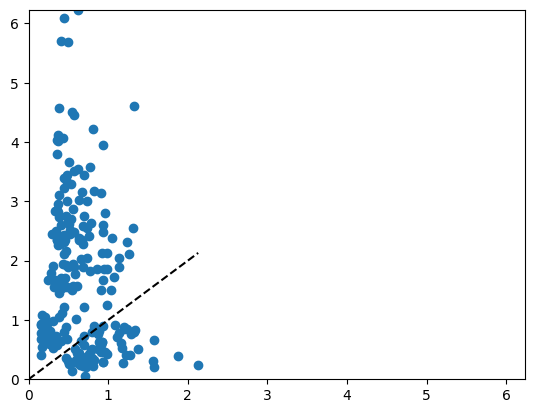

In [51]:
import matplotlib.pyplot as plt

plt.plot(Cs_orig, Cs_norm, 'o')
#set equal aspect ratio
plt.ylim([0, max(max(Cs_orig), max(Cs_norm))])
plt.xlim([0, max(max(Cs_orig), max(Cs_norm))])
#draw a 1:1 line
plt.plot([0,max(Cs_orig)], [0,max(Cs_orig)], 'k--')

In [8]:
layers

[]